# Pose Classification + Height Regression

#### Dataset for pose classification
* convert extracted COCO keypoints into normalized numerical features (X, y)
  - X : 17 keypoints * (x, y, conf) => 51 dimensions
  - y : label2id

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0")

In [2]:
df = pd.read_csv("fifa_pose_keypoints_3class.csv")
mask = df["label"] != "malformed"
df = df[mask].reset_index(drop=True)

In [3]:
kp_cols = [f"kp{i}" for i in range(51)]

labels = sorted(df["new_label"].unique())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

In [4]:
label2id

{'face': 0, 'full_body': 1, 'partial_body': 2}

In [5]:
class PoseClsDataset(Dataset):
    def __init__(self, df):
        self.df = df
        kp_cols = [f"kp{i}" for i in range(51)]
        X_raw = df[kp_cols].values.reshape(-1, 17, 3)

        # drop confidence channel
        X_xy = X_raw[:, :, :2]
        self.X = X_xy.reshape(len(df), -1).astype(np.float32)

        self.y = df["new_label"].map(label2id).values.astype(np.int64)

        # normalize by image size
        self.X /= 256.0
        self.X = np.clip(self.X, 0, 1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [6]:
dataset = PoseClsDataset(df)
n = len(dataset)

train_size = int(0.8 * n)
val_size = n - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

### PoseClassifier model
* a simple multi-layer perceptron
* classify an image resized and passed through the COCO pretrained keypoint R-CNN
* The model does not use raw images, only geometric pose information

In [7]:
class PoseClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

* No activation is applied at the output layer because CrossEntropyLoss expects raw logits

In [8]:
model = PoseClassifier(num_classes=len(labels)).to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [9]:
def evaluate_pose_model(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.append(preds.cpu())
            all_true.append(y.cpu())
    accuracy = correct / total if total > 0 else 0
    return accuracy, torch.cat(all_true), torch.cat(all_preds)

In [10]:
best_accuracy = 0
for epoch in range(1, 31):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * X.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_accuracy, y_true, y_pred = evaluate_pose_model(model, val_loader)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "pose_classifier_best.pt")

    print(f"Epoch {epoch}: train_loss : {train_loss} , val_accuracy : {val_accuracy}")

print("Saved best model to pose_classifier_best.pt")
print("Labels:", labels)

Epoch 1: train_loss : 0.7469543351635912 , val_accuracy : 0.7467811158798283
Epoch 2: train_loss : 0.39225304075576717 , val_accuracy : 0.8583690987124464
Epoch 3: train_loss : 0.28079353982798533 , val_accuracy : 0.9141630901287554
Epoch 4: train_loss : 0.21611504007306734 , val_accuracy : 0.927038626609442
Epoch 5: train_loss : 0.1969689023341232 , val_accuracy : 0.927038626609442
Epoch 6: train_loss : 0.16711640821633933 , val_accuracy : 0.927038626609442
Epoch 7: train_loss : 0.16559193580703163 , val_accuracy : 0.9356223175965666
Epoch 8: train_loss : 0.13271648759749827 , val_accuracy : 0.9613733905579399
Epoch 9: train_loss : 0.11711904623989383 , val_accuracy : 0.9570815450643777
Epoch 10: train_loss : 0.10256174839873171 , val_accuracy : 0.9656652360515021
Epoch 11: train_loss : 0.09730383203776609 , val_accuracy : 0.9656652360515021
Epoch 12: train_loss : 0.09550435946606771 , val_accuracy : 0.9613733905579399
Epoch 13: train_loss : 0.09885434927858508 , val_accuracy : 0.9742

## Height Regression

### load pretrained pose classifier

In [11]:
model = PoseClassifier(num_classes=len(labels)).to(device)
model.load_state_dict(torch.load("pose_classifier_best.pt"))
model.eval()

df = pd.read_csv("fifa_pose_keypoints_raw.csv")

kp_cols = [f"kp{i}" for i in range(51)]

X = df[kp_cols].values.reshape(-1, 17, 3)
X_xy = X[:, :, :2]
X = X_xy.reshape(len(df), -1).astype(np.float32)
X /= 256.0

X_tensor = torch.tensor(X).to(device)

with torch.no_grad():
    logits = model(X_tensor)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

df["pose_pred"] = [id2label[p] for p in preds]

/tmp/ipykernel_157308/3941041906.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pose_classifier_best.pt"))


### pose-based filtering (full_body selection)

In [12]:
df_fullbody = df[df["pose_pred"] == "full_body"].reset_index(drop=True)
print(len(df_fullbody))

390


### dataset and model definition for height estimation

In [13]:
class PoseHeightDataset(Dataset):
    def __init__(self, df):
        kp_cols = [f"kp{i}" for i in range(51)]
        X_raw = df[kp_cols].values.reshape(-1, 17, 3)
        X_xy = X_raw[:, :, :2]
        self.X = (X_xy.reshape(len(df), -1) / 256.0).astype(np.float32)
        self.X = np.clip(self.X, 0, 1)
        self.y = df["height_cm"].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [14]:
class HeightRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [15]:
dataset = PoseHeightDataset(df_fullbody)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

### training and evaluation

In [16]:
model = HeightRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [17]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

    return total_loss / len(loader.dataset)

In [18]:
def evaluate(model, loader):
    model.eval()
    mae = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            mae += torch.abs(pred - y).sum().item()

    return mae / len(loader.dataset)

In [19]:
best_mae = float("inf")

for epoch in range(1, 31):
    train_loss = train_epoch(model, train_loader)
    val_mae = evaluate(model, val_loader)

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), "height_regressor_pose-based_best.pt")

    print(
        f"epoch {epoch} : "
        f"train mse {train_loss:.2f}  "
        f"val mae {val_mae:.2f} cm  "
    )

epoch 1 : train mse 33138.91  val mae 181.69 cm  
epoch 2 : train mse 33014.11  val mae 181.24 cm  
epoch 3 : train mse 32807.97  val mae 180.45 cm  
epoch 4 : train mse 32425.13  val mae 179.02 cm  
epoch 5 : train mse 31782.16  val mae 176.65 cm  
epoch 6 : train mse 30740.38  val mae 172.92 cm  
epoch 7 : train mse 29233.63  val mae 167.39 cm  
epoch 8 : train mse 26993.47  val mae 159.48 cm  
epoch 9 : train mse 24127.08  val mae 148.76 cm  
epoch 10 : train mse 20644.91  val mae 134.93 cm  
epoch 11 : train mse 16388.79  val mae 117.74 cm  
epoch 12 : train mse 12053.86  val mae 97.28 cm  
epoch 13 : train mse 7934.87  val mae 74.37 cm  
epoch 14 : train mse 4586.30  val mae 50.63 cm  
epoch 15 : train mse 2386.82  val mae 29.33 cm  
epoch 16 : train mse 1155.42  val mae 17.26 cm  
epoch 17 : train mse 940.37  val mae 15.19 cm  
epoch 18 : train mse 945.14  val mae 15.48 cm  
epoch 19 : train mse 847.70  val mae 15.29 cm  
epoch 20 : train mse 1009.33  val mae 15.16 cm  
epoch 21 

In [20]:
model = HeightRegressor().to(device)
model.load_state_dict(torch.load("height_regressor_pose-based_best.pt"))
model.eval()

val_mae = evaluate(model, val_loader)
print(f"final validation mae: {val_mae:.2f} cm")

final validation mae: 15.02 cm


/tmp/ipykernel_157308/2914930992.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("height_regressor_pose-based_best.pt"))


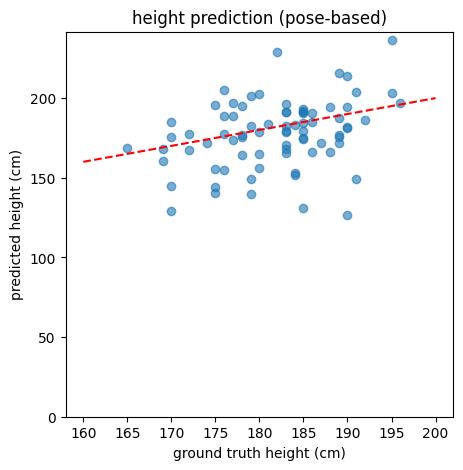

In [21]:
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        pred = model(X).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(y.numpy())

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([160, 200], [160, 200], 'r--')
plt.xlabel("ground truth height (cm)")
plt.ylabel("predicted height (cm)")
plt.title("height prediction (pose-based)")

plt.ylim(bottom=0) 
plt.show()